## В порядок привести ноутбук не успел, НЕ рекомендуется к прочтению

In [21]:
import numpy as np 
import pandas as pd
import matplotlib as mpl 
import matplotlib.pyplot as plt 

from sklearn.linear_model import Lasso, LassoCV, Ridge
from sklearn.model_selection import cross_val_predict, train_test_split

from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import AlphaSelection, PredictionError, ResidualsPlot

mpl.rcParams['figure.figsize'] = (20,12)

#### Load Data

Yellowbrick provides several datasets wrangled from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/). For the following examples, we'll use the `concrete` dataset, since it is well-suited for regression tasks.

The `concrete` dataset contains 1030 instances and 9 attributes. Eight of the attributes are explanatory variables, including the age of the concrete and the materials used to create it, while the target variable `strength` is a measure of the concrete's compressive strength (MPa).

In [41]:
#import pickle
#with open("../dataloaders.pkl", "rb") as file:
#    train_dataloader, val_dataloader, test_dataloader = pickle.load(file)

#X_train, y_train = train_dataloader.dataset.tensors
#X_test, y_test = val_dataloader.dataset.tensors
#X_train, y_train, X_test, y_test = X_train.numpy(), y_train.numpy(), X_test.numpy(), y_test.numpy()
#X = np.concatenate((X_train, X_test))
#y = np.concatenate((y_train, y_test))

In [138]:
import torch
from tqdm import trange
from typing import Tuple
import pandas as pd
from omegaconf import OmegaConf
cfg = OmegaConf.load("./config.yaml")

df_train_path = f"../{cfg.paths.data_directory}/prostata_filtered.csv"
df_train = pd.read_csv(df_train_path)

y = df_train["ddg"]
X = df_train[["pdb_id", "mut_info", "chain", "mutations", "positions", "pos"]]
X = pd.get_dummies(X, columns=["pdb_id", "mut_info", "chain", "mutations", "positions"])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)
X_train

,pos,pdb_id_1A23,pdb_id_1A43,pdb_id_1AAR,pdb_id_1AG2,pdb_id_1AJ3,pdb_id_1AKK,pdb_id_1AKY,pdb_id_1AM7,pdb_id_1ANF,...,positions_X:147,positions_X:1699,positions_X:170,positions_X:1775,positions_X:1833,positions_X:43,positions_X:54,positions_X:56,positions_X:79,positions_X:81
115,2,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2247,32,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1845,36,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2216,97,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1694,21,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,28,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1095,24,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1130,19,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1294,7,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [139]:
from sklearn.ensemble import RandomForestRegressor

feature_names = list(X.columns)
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)

from metrics import compute_metrics
compute_metrics(y_test, forest.predict(X_test))

{'R2': 0.3479714333092082,
 'RMSE': 1.319097823946748,
 'Pearson': 0.6000239904156409,
 'Spearman': 0.5209541195723116,
 'StabSpearman': 0.3599865093743017,
 'DetPr': 0.6959798994974874,
 'nDCG': 0.8098047550465448,
 'MCC': 0.36532212374862966,
 'AUC': 0.7569919563609466,
 'ACC': 0.6936026936026936}

In [131]:
import time

import numpy as np

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.016 seconds


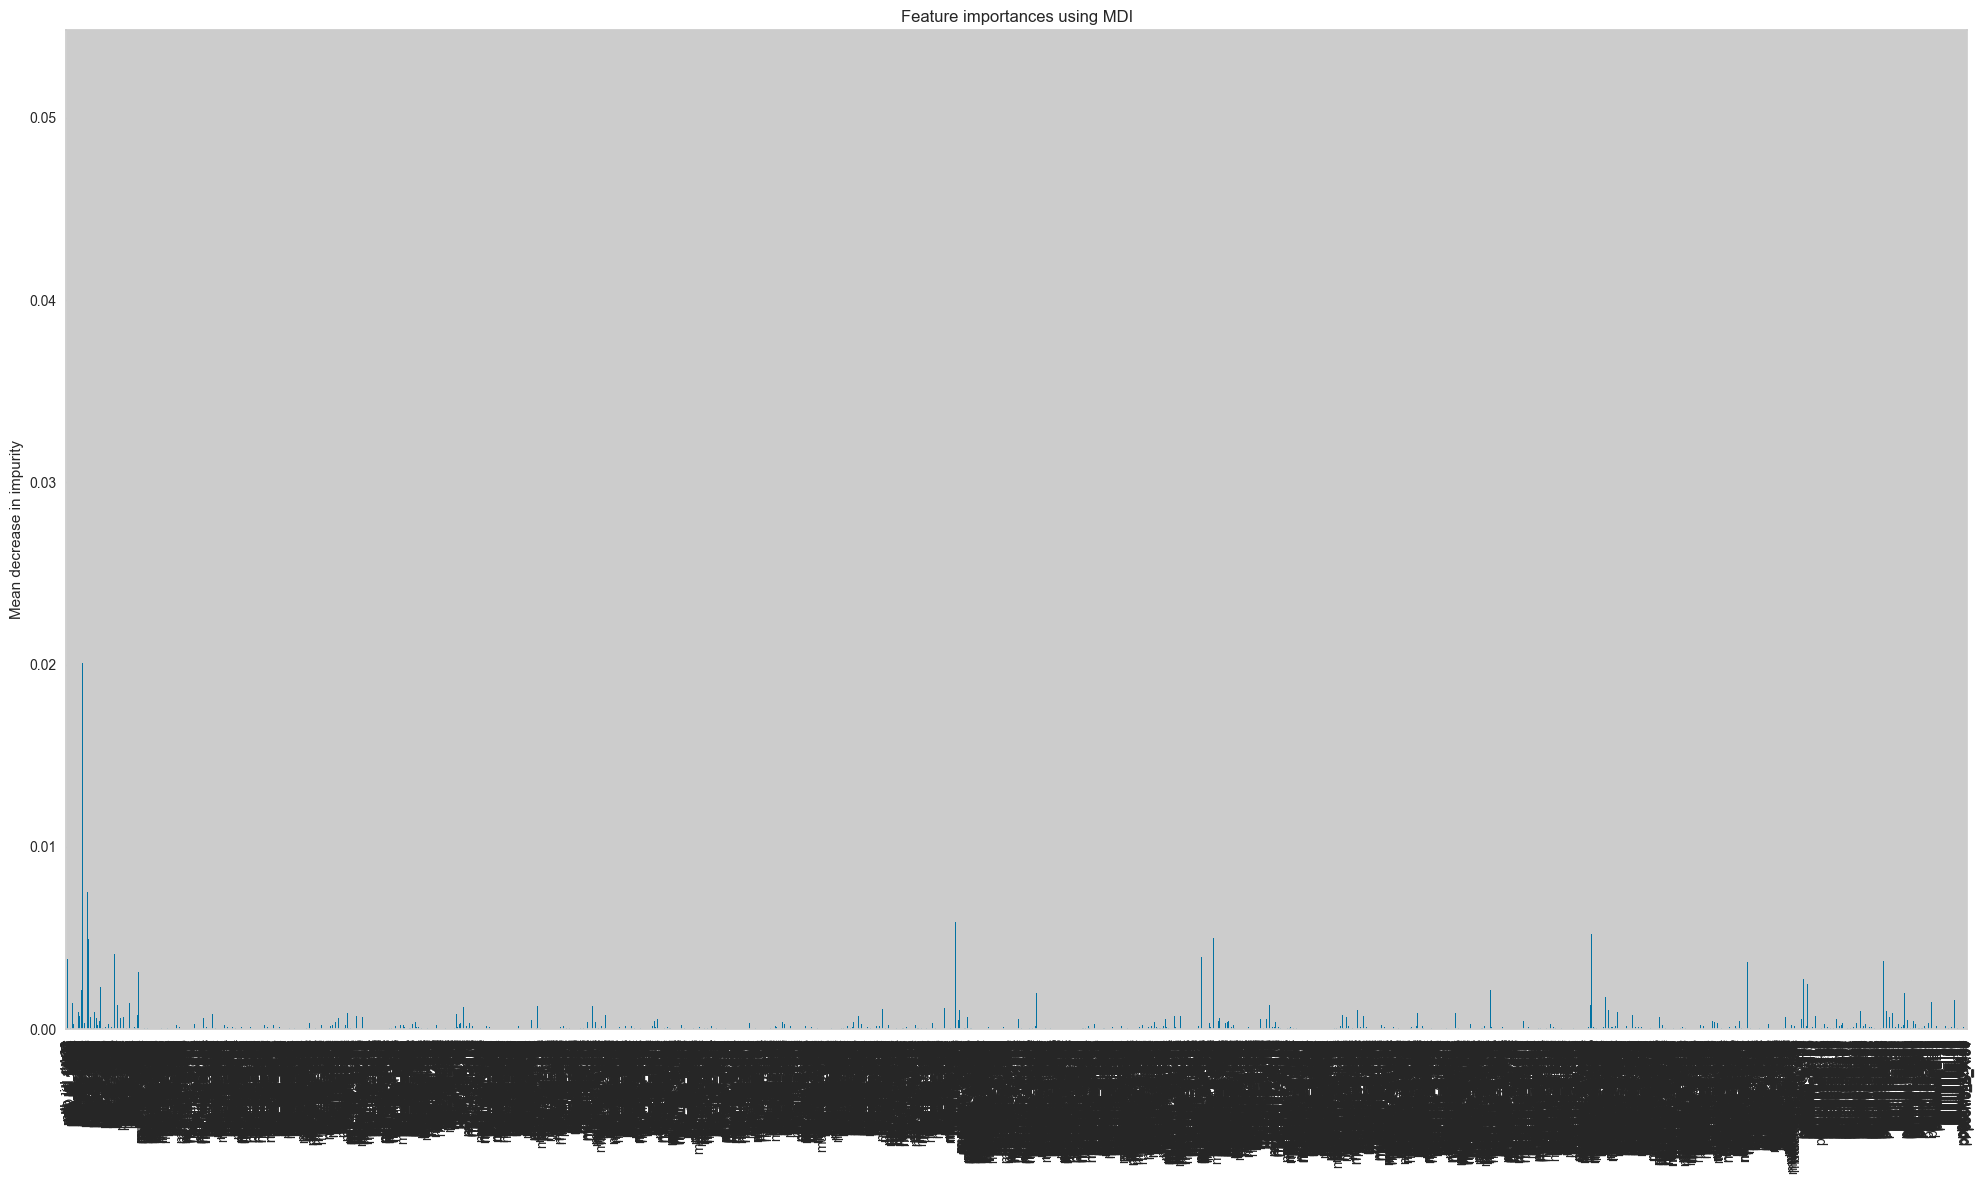

In [132]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [133]:
THRESHOLD = 0.005
best_features = forest_importances[forest_importances > THRESHOLD]
print("len(X):", len(best_features))

#list(best_features.index)
X_best = X[best_features.index]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_best, y, random_state=42, test_size=0.25)
X_train

len(X): 30


,pos,pdb_id_1CAH,pdb_id_1CLW,pdb_id_1EM7,pdb_id_1FEP,pdb_id_1HMS,pdb_id_1QLP,pdb_id_1RTB,pdb_id_1TEN,pdb_id_1YYJ,...,mutations_A:R382S,mutations_A:V13G,mutations_A:Y97A,mutations_A:Y97G,positions_A:107,positions_A:155,positions_A:49,positions_A:53,positions_A:79,positions_A:97
115,2,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2247,32,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1845,36,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2216,97,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1694,21,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,28,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1095,24,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1130,19,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1294,7,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [134]:
best_forest = RandomForestRegressor(random_state=42)
best_forest.fit(X_train, y_train)

from metrics import compute_metrics
compute_metrics(y_test, best_forest.predict(X_test))

{'R2': 0.10831148603519403,
 'RMSE': 1.5425891713733173,
 'Pearson': 0.44372918719471577,
 'Spearman': 0.24860062868553354,
 'StabSpearman': 0.1616267078253819,
 'DetPr': 0.6096579476861167,
 'nDCG': 0.7269066270231808,
 'MCC': 0.18573513371695968,
 'AUC': 0.6247977533284024,
 'ACC': 0.6144781144781145}

### Residuals Plot 

A residual is the difference between the observed value of the target variable (y) and the predicted value (ŷ), i.e. the error of the prediction. The `ResidualsPlot` Visualizer shows the difference between residuals on the vertical axis and the dependent variable on the horizontal axis, allowing you to detect regions within the target that may be susceptible to more or less error. 

If the points are randomly dispersed around the horizontal axis, a linear regression model is usually well-suited for the data; otherwise, a non-linear model is more appropriate. The following example shows a fairly random, uniform distribution of the residuals against the target in two dimensions. This seems to indicate that our linear model is performing well.

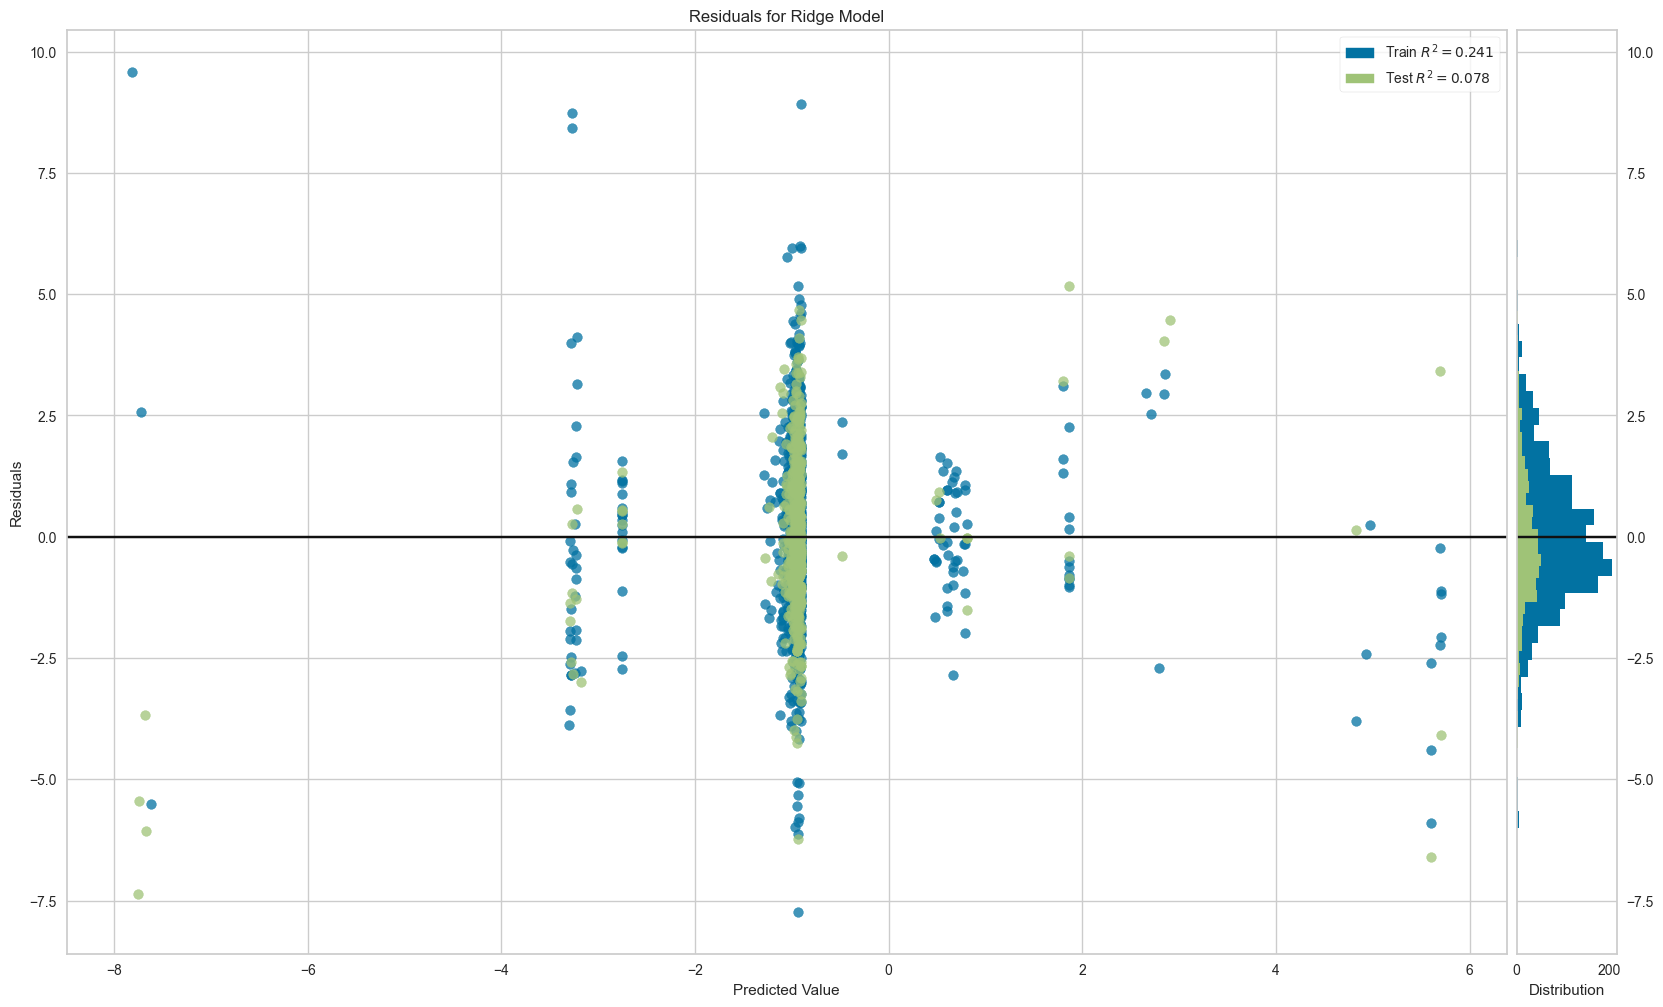

<Axes: title={'center': 'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [112]:
# Instantiate the linear model and visualizer 
model = Ridge()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data 
visualizer.show()                       # Finalize and render the figure

Yellowbrick's `ResidualsPlot` Visualizer also displays a histogram of the error values along the right-hand side. In the example above, the error is normally distributed around zero, which also generally indicates a well-fitted model. If the histogram is not desired, it can be turned off with the `hist=False` flag.

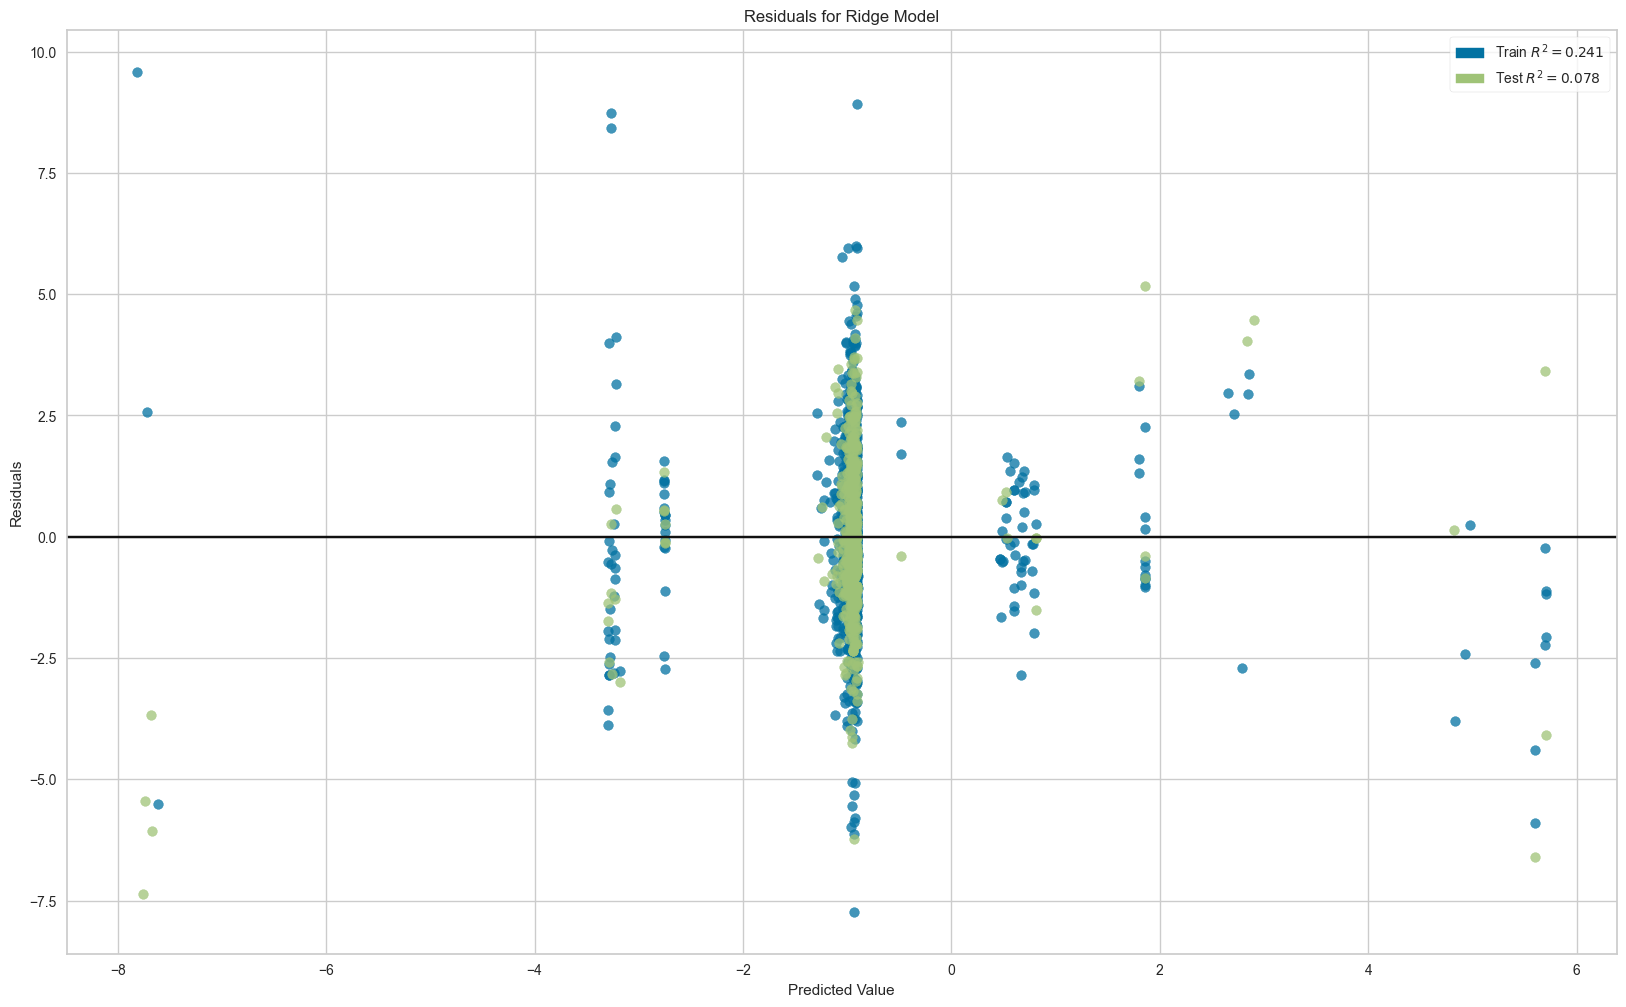

<Axes: title={'center': 'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [113]:
# Instantiate the linear model and visualizer 
model = Ridge()
visualizer = ResidualsPlot(model, hist=False)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data 
visualizer.show()                       # Finalize and render the figure

### Prediction Error Plot 

Yellowbrick's `PredictionError` Visualizer plots the actual targets from the dataset against the predicted values generated by the model. This allows us to see how much variance is in the model. Data scientists can diagnose regression models using this plot by comparing against the 45-degree line, where the prediction exactly matches the model.

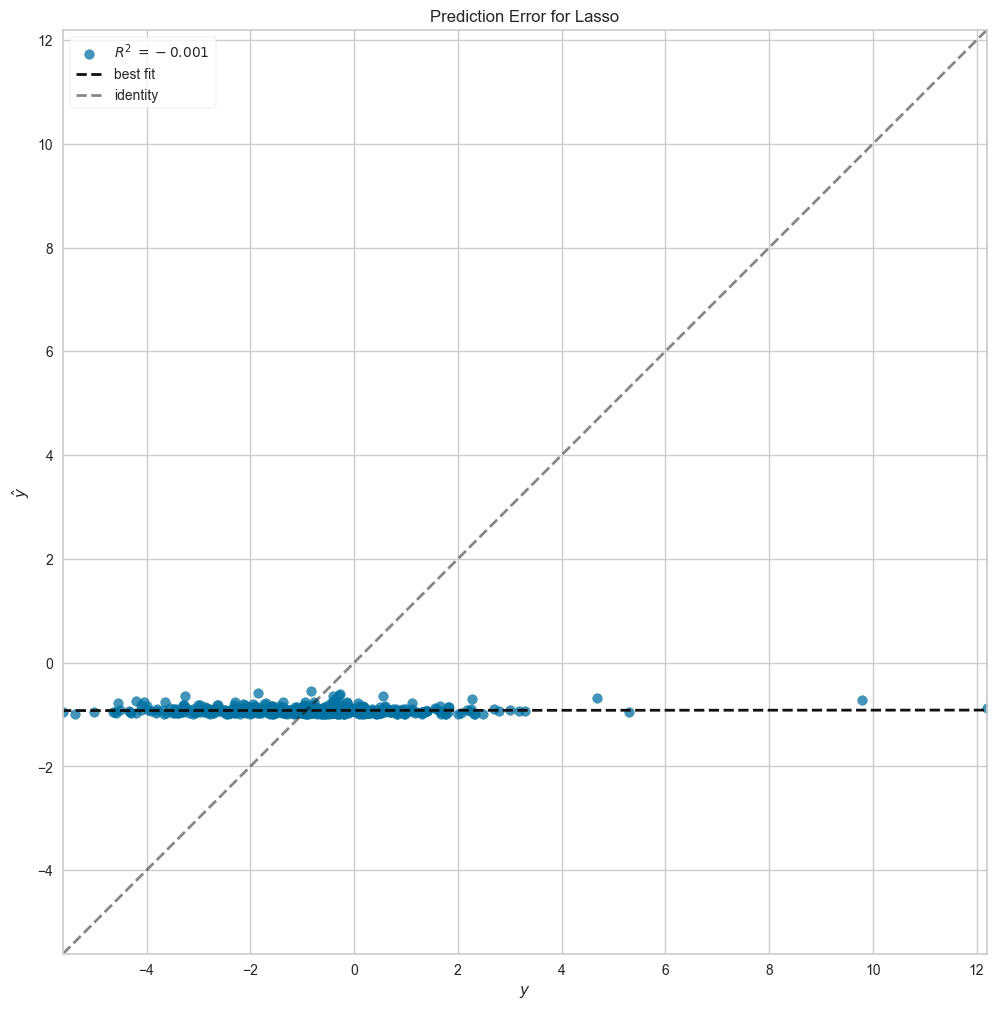

<Axes: title={'center': 'Prediction Error for Lasso'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [114]:
# Instantiate the linear model and visualizer 
model = Lasso()
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data 
visualizer.show()                       # Finalize and render the figure

### Alpha Selection Visualizer

The `AlphaSelection` Visualizer demonstrates how different values of alpha influence model selection during the regularization of linear models. Since regularization is designed to penalize model complexity, the higher the alpha, the less complex the model, decreasing the error due to variance (overfit). However, alphas that are too high increase the error due to bias (underfit). Therefore, it is important to choose an optimal alpha such that the error is minimized in both directions.

To do this, typically you would you use one of the "RegressionCV” models in scikit-learn. E.g. instead of using the `Ridge` (L2) regularizer, use `RidgeCV` and pass a list of alphas, which will be selected based on the cross-validation score of each alpha. This visualizer wraps a “RegressionCV” model and visualizes the alpha/error curve. If the visualization shows a jagged or random plot, then potentially the model is not sensitive to that type of regularization and another is required (e.g. L1 or Lasso regularization).

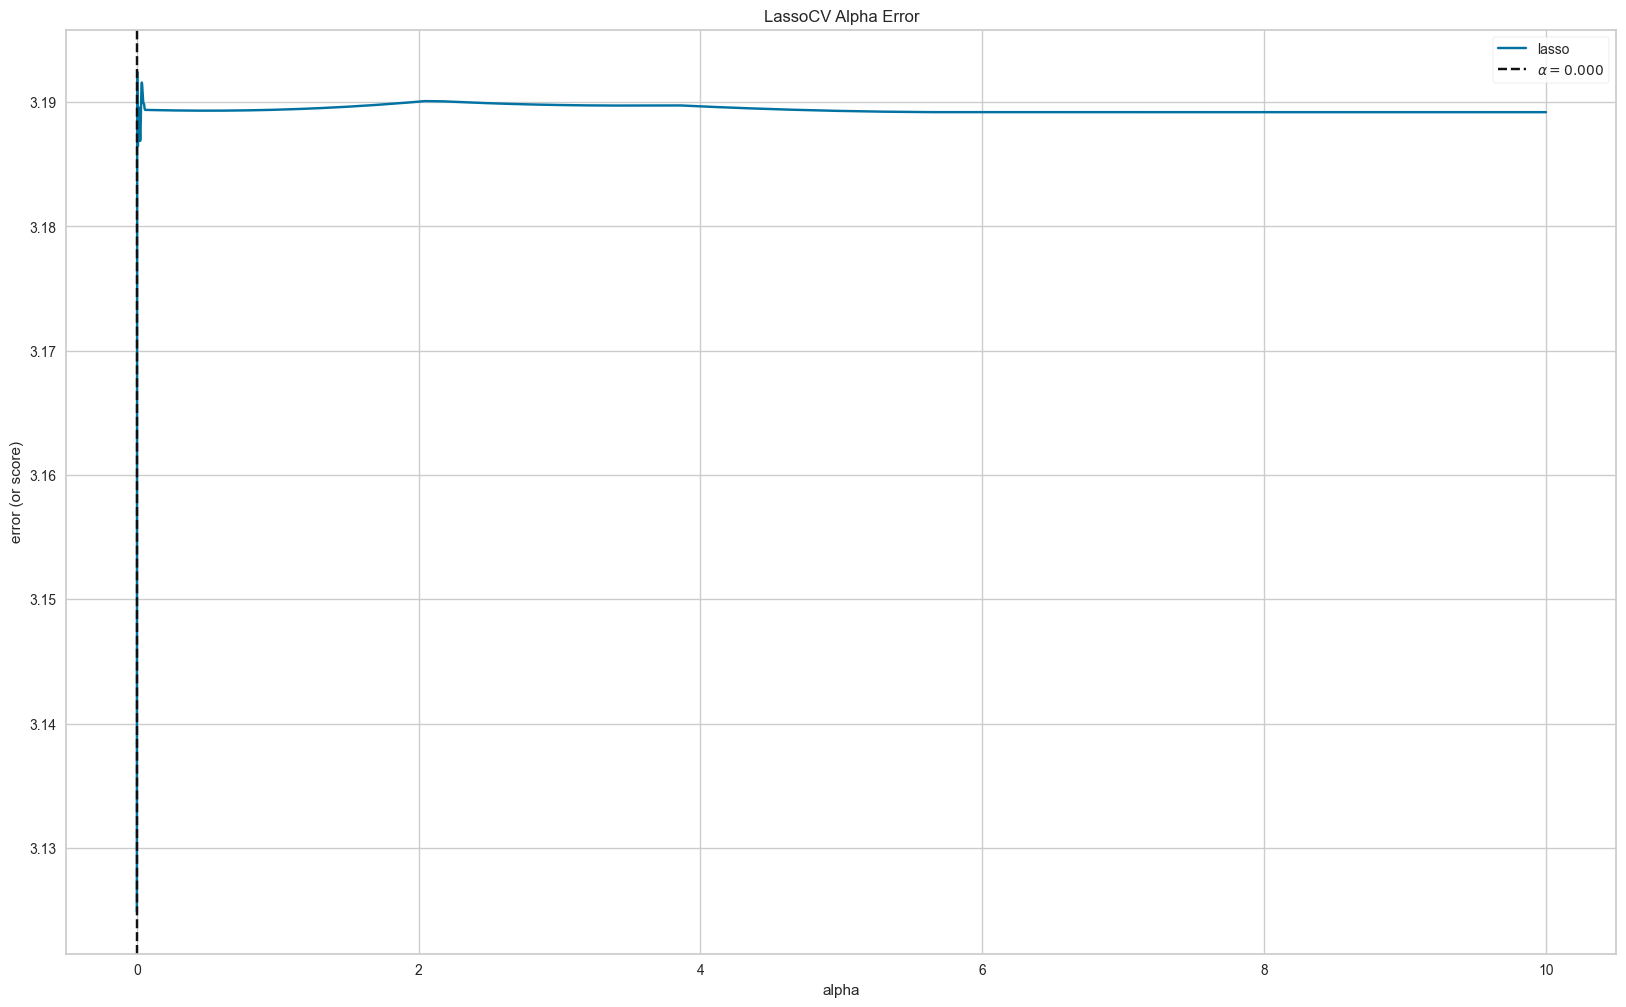

<Axes: title={'center': 'LassoCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [115]:
# Create a list of alphas to cross-validate against 
alphas = np.logspace(-10, 1, 400)

# Instantiate the linear model and visualizer 
model = LassoCV(alphas=alphas, cv=3, tol=1)
visualizer = AlphaSelection(model)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure